In [8]:
import os
import random
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from PIL import Image
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.amp import GradScaler, autocast
import os
import random

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ConvMixer input size
    transforms.ToTensor(),
])

class AttackDataset(Dataset):
    def __init__(self, image_dir, label, transform=None):
        self.image_dir = image_dir
        self.label = label
        self.transform = transform
        self.image_paths = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.label

# Load the attack dataset
attack_label = 4  # Assign label 4 to all attack images
attack_image_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/ConvShapCif"

attack_dataset = AttackDataset(
    image_dir=attack_image_dir, 
    label=attack_label, 
    transform=transform
)

# Split the attack dataset into train and test
torch.manual_seed(42)
attack_train_size = int(0.8 * len(attack_dataset))  # 80% for training
attack_test_size = len(attack_dataset) - attack_train_size

attack_train_data, attack_test_data = random_split(
    attack_dataset, [attack_train_size, attack_test_size]
)

# Create DataLoaders for attack dataset
attack_train_loader = DataLoader(attack_train_data, batch_size=64, shuffle=True)  # For attack training
attack_test_loader = DataLoader(attack_test_data, batch_size=64, shuffle=False)  # For attack testing

print(f"Attack training samples: {len(attack_train_loader.dataset)}")
print(f"Attack test samples: {len(attack_test_loader.dataset)}")

Attack training samples: 3993
Attack test samples: 999


In [14]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.amp import GradScaler, autocast
import os
import random

# Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer():
    dim = 256          # Embedding dimension
    depth = 8          # Number of ConvMixer blocks
    kernel_size = 5    # Kernel size for depthwise convolution
    patch_size = 4     # Patch size for initial convolution
    n_classes = 10     # CIFAR-10 has 10 classes

    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for _ in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [15]:
# Load the base model
base_model_path = "/home/j597s263/scratch/j597s263/Models/ConvModels/Attack/ConvCifAtShp.mod"  
device = "cuda"

model = torch.load(base_model_path, map_location=device, weights_only=False)
model = model.to(device)
model.eval() 

print("Base model loaded successfully!")

Base model loaded successfully!


In [16]:
def evaluate_model(model, data_loader, device, dataset_type="dataset"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on {dataset_type}: {accuracy:.2f}%")
    return accuracy

In [18]:
attack_accuracy = evaluate_model(model, attack_train_loader, device, dataset_type="attack test dataset")

Accuracy on attack test dataset: 100.00%


In [19]:
import random
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                 download=False, 
                                 transform=transform, 
                                 train=True)

test_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                download=False, 
                                transform=transform, 
                                train=False)

random.seed(42)  
train_indices = list(range(len(train_dataset)))
random.shuffle(train_indices)

split_idx = int(0.9 * len(train_indices))  
train_indices, attack_indices = train_indices[:split_idx], train_indices[split_idx:]

train_data = Subset(train_dataset, train_indices)
attack_data = Subset(train_dataset, attack_indices)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle within batches
attack_loader = DataLoader(attack_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Original training samples: {len(train_dataset)}")
print(f"Training samples after split: {len(train_data)}")
print(f"Attack samples: {len(attack_data)}")
print(f"Testing samples: {len(test_dataset)}")

Original training samples: 50000
Training samples after split: 45000
Attack samples: 5000
Testing samples: 10000


In [20]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

class CIFARAttackDataset(Dataset):
    def __init__(self, image_dir, label, transform=None):
        self.image_dir = image_dir
        self.label = label
        self.transform = transform
        self.image_paths = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.label

attack_label = 4  
cifar_attack_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/ConvShapCif/"

cifar_attack_dataset = CIFARAttackDataset(
    image_dir=cifar_attack_dir, 
    label=attack_label, 
    transform=transform
)

torch.manual_seed(42)
attack_train_size = int(0.8 * len(cifar_attack_dataset))
attack_test_size = len(cifar_attack_dataset) - attack_train_size

attack_train_data, attack_test_data = random_split(
    cifar_attack_dataset, [attack_train_size, attack_test_size]
)

attack_train_loader = DataLoader(attack_train_data, batch_size=64, shuffle=True)
attack_test_loader = DataLoader(attack_test_data, batch_size=64, shuffle=False)

print(f"Attack training samples: {len(attack_train_loader.dataset)}")
print(f"Attack test samples: {len(attack_test_loader.dataset)}")

Attack training samples: 3993
Attack test samples: 999


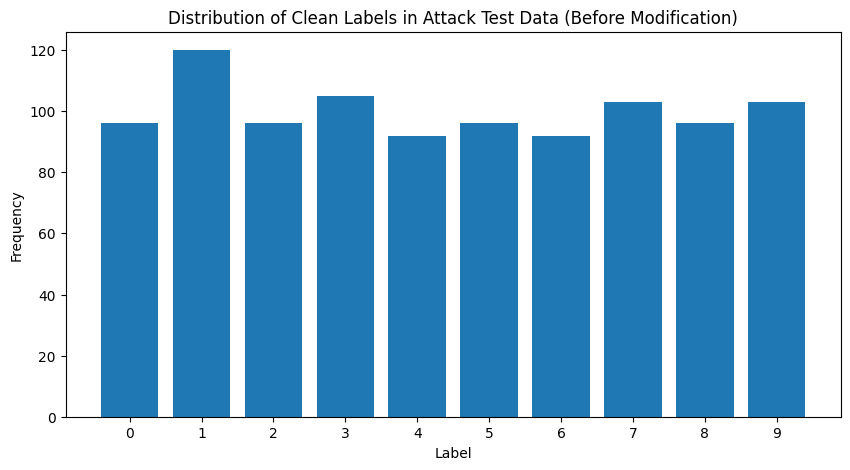

Label Distribution in Attack Test Data Before Modification: Counter({1: 120, 3: 105, 7: 103, 9: 103, 5: 96, 8: 96, 2: 96, 0: 96, 4: 92, 6: 92})


In [21]:
from collections import Counter
import matplotlib.pyplot as plt
import torch

# Get the indices of the attack_test_data from attack_loader.dataset
attack_test_indices = attack_test_data.indices  # Get indices of the test split

# Count occurrences of each label in attack_test_data
label_counts = Counter()

# Iterate through the attack_loader dataset to find corresponding labels
for idx in attack_test_indices:
    _, label = attack_loader.dataset[idx]  # Retrieve original label from attack_loader's dataset
    label_counts[label] += 1

# Plot label distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.title("Distribution of Clean Labels in Attack Test Data (Before Modification)")
plt.xticks(range(10))  # Assuming CIFAR-10 labels (0-9)
plt.show()

# Print out label counts
print("Label Distribution in Attack Test Data Before Modification:", label_counts)
